# Tuberculosis Classification Using different types of Transfer Learning Approach

### By Sheshu Babu, Sachin Saj

- The task is to classify, whether the given chest X-Ray has tuberculosis or not.

- The dataset, which has been used for our task is Montogomery County X-Ray dataset. Preprocessing steps like data-augmentation and histogram equalizations is done to improve their performances.

- The pre-trained models used were MobileNetV2 and DenseNet121 (** In this notebook, only mobilenetV2 is shown). The reason for choosing this models were because of their light weight architecture as a result computation time were be reduced

- Three modes of tuning were used: a) Shallow Tuning, b) Deep Tuning, c) Fine tuning. Shallow tuning means, only the last layer is kept trainable. In fine tuning, layer by layer is made trainable and kept rest of the layers frozen. In deep tuning, it is nothing but complete retraining of the model with this dataset (high time consuming).

- In conclusion, the order of their performance: Deep Tuning > Fine Tuning > Shallow Tuning

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D
from sklearn.preprocessing import Normalizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_curve, auc
import os
import sys
import cv2
import shutil

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imgaug import augmenters as imaug
import skimage.io as skio

from skimage.exposure import histogram
from skimage import data, img_as_float
from skimage import exposure

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras import optimizers
from keras.callbacks import ModelCheckpoint,CSVLogger

Using TensorFlow backend.


In [3]:
#--------------------------------------------------- Func to load Data---------------------------------------------------#

def loadData(aug_path,m,n):
    image = []
    label = []
    folders = os.listdir(aug_path)
    for folder in folders:
        folderpath = os.path.join(aug_path,folder)
        if folder == 'MontgomerySet':
            subfolders = os.listdir(folder)
            for subfolder in subfolders:
                print(subfolder)
                if subfolder == 'CXR_png':
                    subfolder_path = os.path.join(folderpath,subfolder)
                    print(subfolder_path)
                    fulldata = os.listdir(subfolder_path)
                    for data in fulldata:
                        if (data.endswith('.png')):
                            datapath = os.path.join(subfolder_path,data)
                            print(datapath)
                            img = cv2.resize(cv2.imread(datapath),(m,n))
                            im = img
                            for style in aug_types:
                                newimg = augmenter(im,style)
                                save_path = datapath +"-"+ style +".png"
                                cv2.imwrite(save_path,newimg)
                                b,g,r = cv2.split(newimg)
                                img_eq1 = exposure.equalize_hist(b)
                                img_eq2 = exposure.equalize_hist(g)
                                img_eq3 = exposure.equalize_hist(r)
                                img_eq = np.zeros((m,n,3))
                                img_eq[:,:,0] = img_eq1
                                img_eq[:,:,1] = img_eq2
                                img_eq[:,:,2] = img_eq3
                                plt.imshow(img_eq)             
                                image.append(img_eq)
                                path_split = datapath.split("\\")
                                newpath = path_split[-1]
                                label.append(newpath[12])
    image = np.array(image)
    label = np.array(label)
    return image,label

.DS_Store
ClinicalReadings
CXR_png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0001_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0002_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0003_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0004_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0005_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0006_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0008_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0011_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0013_0.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\

D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0142_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0144_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0150_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0162_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0166_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0170_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0173_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0182_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0188_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR_png\MCUCXR_0194_1.png
D:\CEN\Sem 3 CEN\Sowmya mam(Bio medical)\tuberclosis\MontgomerySet\CXR

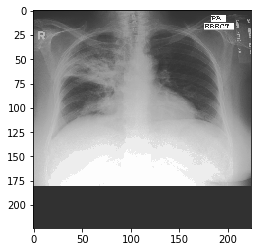

In [4]:
#------------------------------------------ Augumentation Types------------------------------------------------------------#

aug_types = {"Flip","Crop","Gaussian Blur","Gaussian Noise","Contrast","Multiply","Affine","Scale","Rotate","Original"}
aug_path = 'D:\\CEN\\Sem 3 CEN\\Sowmya mam(Bio medical)\\tuberclosis'
m = 224
n = 224
image,label = loadData(aug_path,m,n)

In [2]:
def augmenter(image,style):
    if (style =="Flip" ):
        aug_img = imaug.Sequential([imaug.Fliplr(0.5)]).augment_image(image)         
    elif(style == "Crop"):
        aug_img = imaug.Sequential([imaug.Crop(percent = (0,0.1))]).augment_image(image)
    elif(style == "Gaussian Blur"):    
        aug_img = imaug.Sequential([imaug.GaussianBlur(sigma = (0,3.0))]).augment_image(image)
    elif(style == "Gaussian Noise"):
        aug_img = imaug.Sequential([imaug.AdditiveGaussianNoise(scale = (0.0,0.2))]).augment_image(image)
    elif(style == "Contrast" ):
        aug_img = imaug.Sequential([imaug.ContrastNormalization(0.5,per_channel = 0.5)]).augment_image(image)
    elif(style == "Multiply" ):
        aug_img = imaug.Sequential([imaug.Multiply((0.8,1.2))]).augment_image(image)
    elif(style == "Affine" ):
        aug_img = imaug.Sequential([imaug.Crop(percent = (0,0.1))]).augment_image(image)
    elif(style == "Scale" ):
        aug_img = imaug.Sequential([imaug.Affine(scale = {"x": (0.8,1.2),"y": (0.8,1.2)})]).augment_image(image)
    elif(style == "Rotate" ):
        aug_img = imaug.Sequential([imaug.Affine(rotate = (30))]).augment_image(image)
    elif(style == "Original"):
        aug_img = image

    return aug_img

In [15]:
print(label,'\n')
print(image.shape)
print(label.shape)

['0' '0' '0' ... '1' '1' '1'] 

(1380, 224, 224, 3)
(1380,)


In [16]:
# ----------------------------------------Train-Test Split---------------------------------------------#

X_train, X_test, y_train, y_test = train_test_split(image, label, test_size=0.1, random_state = 30)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1242, 224, 224, 3)
(1242,)
(138, 224, 224, 3)
(138,)


In [17]:
le=LabelEncoder()
y11=le.fit_transform(y_test)
y1_test = to_categorical(y11, 2)
print(y1_test.shape)

(138, 2)


In [18]:
#--------------------------------------------Train-Valid Split-------------------------------------------------------#

train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2, random_state = 25)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)


(993, 224, 224, 3)
(993,)
(249, 224, 224, 3)
(249,)


In [19]:
le1=LabelEncoder()
le2=LabelEncoder()
y1=le1.fit_transform(train_y)
y2=le2.fit_transform(valid_y)
y1_train = to_categorical(y1, 2)
y1_valid = to_categorical(y2, 2)
print(y1_train.shape)
print(y1_valid.shape)

(993, 2)
(249, 2)


In [72]:
# --------------------------------------------- Pre-Trained MobileV2Net--------------------------------------------------#

mobilev2 = MobileNetV2(input_shape=(m,n,3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=None, pooling=None)
mobilev2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [23]:
# ----------- Note:
# ----------- If the last layer alone made trainable and rest layers is been freezed, then it is shallow tunning (in transfer learning approach)
# ----------- If we start making layer by layer trainable from last, that is called fine tunning (in transfer learning approach)
# ----------- Now fine tuning of the network is been done, in subsequent cells...

for layer in frez1.layers[:-2]:
    layer.trainable = False    

In [33]:
model1 = Sequential()
model1.add(mobilev2)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(2,activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 5,122
Non-trainable params: 2,255,424
_________________________________________________________________


In [34]:
sgd = optimizers.SGD(lr=0.001, decay=0.001, momentum=0.9, nesterov=False)
model1.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [36]:
checkpoint = ModelCheckpoint(filepath = 'E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint1(2layers)/checkpoint-{epoch:02d}.hdf5',
                             verbose=1,
                             save_best_only = True,
                             monitor='val_loss')

csvLogger = CSVLogger(filename='E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint1(2layers)/logger.csv',
                      append=True,
                      separator=',')

In [37]:
model1.fit(train_x,y1_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(valid_x,y1_valid),
         callbacks=[checkpoint,csvLogger])

model1.save('E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint1(2layers)/model1.hdf5')

W0730 11:22:05.806278  8612 deprecation.py:323] From C:\Users\seshubabu\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 993 samples, validate on 249 samples
Epoch 1/100
993/993 [==============================] - 158s 159ms/step - loss: 0.7895 - acc: 0.4975 - val_loss: 1.4121 - val_acc: 0.5261

Epoch 00001: val_loss improved from inf to 1.41215, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint1(2layers)/checkpoint-01.hdf5
Epoch 2/100
993/993 [==============================] - 164s 165ms/step - loss: 0.7422 - acc: 0.5841 - val_loss: 1.3244 - val_acc: 0.5261

Epoch 00002: val_loss improved from 1.41215 to 1.32439, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint1(2layers)/checkpoint-02.hdf5
Epoch 3/100
993/993 [==============================] - 260s 262ms/step - loss: 0.6793 - acc: 0.5952 - val_loss: 1.2794 - val_acc: 0.5261

Epoch 00003: val_loss improved from 1.32439 to 1.27943, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint1(2layers)/checkpoint-03.hdf5
Epoch 4/100
993/993 [=============

993/993 [==============================] - 272s 273ms/step - loss: 0.3347 - acc: 0.8751 - val_loss: 2.4008 - val_acc: 0.5261

Epoch 00042: val_loss did not improve from 1.27943
Epoch 43/100
993/993 [==============================] - 279s 281ms/step - loss: 0.3314 - acc: 0.8852 - val_loss: 2.3959 - val_acc: 0.5261

Epoch 00043: val_loss did not improve from 1.27943
Epoch 44/100
993/993 [==============================] - 261s 263ms/step - loss: 0.3278 - acc: 0.8872 - val_loss: 2.4423 - val_acc: 0.5261

Epoch 00044: val_loss did not improve from 1.27943
Epoch 45/100
993/993 [==============================] - 177s 178ms/step - loss: 0.3296 - acc: 0.8862 - val_loss: 2.4748 - val_acc: 0.5261

Epoch 00045: val_loss did not improve from 1.27943
Epoch 46/100
993/993 [==============================] - 176s 178ms/step - loss: 0.3226 - acc: 0.8943 - val_loss: 2.3995 - val_acc: 0.5261

Epoch 00046: val_loss did not improve from 1.27943
Epoch 47/100
993/993 [==============================] - 176s 17

In [38]:
test_loss1 = model1.evaluate(X_test,y1_test)

138/138 [==============================] - 21s 155ms/step


In [39]:
print(test_loss1)

[2.336960022000299, 0.5724637672521066]


In [40]:
predictions1 = model1.predict(X_test,verbose=1)

138/138 [==============================] - 23s 168ms/step


In [41]:
prediction1 = np.argmax(predictions1,axis=1)
prediction1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [44]:
# ------ Now last 3 layers is made trainable and rest layers is made freezed

for layer in frez2.layers[:-3]:
    layer.trainable = False    

In [47]:
model2 = Sequential()
model2.add(frez2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(2,activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 414,722
Non-trainable params: 1,845,824
_________________________________________________________________


In [48]:
sgd = optimizers.SGD(lr=0.001, decay=0.001, momentum=0.9, nesterov=False)
model2.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])

In [50]:
checkpoint = ModelCheckpoint(filepath = 'E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint2(3layers)/checkpoint-{epoch:02d}.hdf5',
                             verbose=1,
                             save_best_only = True,
                             monitor='val_loss')

csvLogger = CSVLogger(filename='E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint2(3layers)/logger.csv',
                      append=True,
                      separator=',')

In [51]:
model2.fit(train_x,y1_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(valid_x,y1_valid),
           callbacks=[checkpoint,csvLogger])

model2.save('E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint2(3layers)/model1.hdf5')

Train on 993 samples, validate on 249 samples
Epoch 1/100
993/993 [==============================] - 262s 263ms/step - loss: 0.2526 - acc: 0.9255 - val_loss: 2.7603 - val_acc: 0.5261

Epoch 00001: val_loss improved from inf to 2.76029, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint2(3layers)/checkpoint-01.hdf5
Epoch 2/100
993/993 [==============================] - 266s 268ms/step - loss: 0.2487 - acc: 0.9225 - val_loss: 2.7091 - val_acc: 0.5261

Epoch 00002: val_loss improved from 2.76029 to 2.70907, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint2(3layers)/checkpoint-02.hdf5
Epoch 3/100
993/993 [==============================] - 265s 266ms/step - loss: 0.2483 - acc: 0.9225 - val_loss: 2.6920 - val_acc: 0.5261

Epoch 00003: val_loss improved from 2.70907 to 2.69205, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint2(3layers)/checkpoint-03.hdf5
Epoch 4/100
993/993 [=============

993/993 [==============================] - 167s 168ms/step - loss: 0.2376 - acc: 0.9335 - val_loss: 2.8013 - val_acc: 0.5261

Epoch 00042: val_loss did not improve from 2.69205
Epoch 43/100
993/993 [==============================] - 167s 168ms/step - loss: 0.2250 - acc: 0.9396 - val_loss: 2.7601 - val_acc: 0.5261

Epoch 00043: val_loss did not improve from 2.69205
Epoch 44/100
993/993 [==============================] - 165s 166ms/step - loss: 0.2188 - acc: 0.9446 - val_loss: 2.8001 - val_acc: 0.5261

Epoch 00044: val_loss did not improve from 2.69205
Epoch 45/100
993/993 [==============================] - 187s 189ms/step - loss: 0.2208 - acc: 0.9406 - val_loss: 2.8622 - val_acc: 0.5261

Epoch 00045: val_loss did not improve from 2.69205
Epoch 46/100
993/993 [==============================] - 263s 265ms/step - loss: 0.2218 - acc: 0.9325 - val_loss: 2.8335 - val_acc: 0.5261

Epoch 00046: val_loss did not improve from 2.69205
Epoch 47/100
993/993 [==============================] - 262s 26

In [52]:
test_loss2 = model2.evaluate(X_test,y1_test)

138/138 [==============================] - 15s 111ms/step


In [53]:
predictions2 = model2.predict(X_test,verbose=1)

138/138 [==============================] - 15s 106ms/step


In [54]:
prediction2 = np.argmax(predictions2,axis=1)
prediction2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [57]:
# ------ Now last 4 layers is made trainable and rest layers is made freezed

for layer in frez3.layers[:-4]:
    layer.trainable = False    

In [64]:
model3 = Sequential()
model3.add(frez3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(2,activation='softmax'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 415,362
Non-trainable params: 1,845,184
_________________________________________________________________


In [65]:
sgd = optimizers.SGD(lr=0.001, decay=0.001, momentum=0.9, nesterov=False)
model3.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])

In [67]:
checkpoint = ModelCheckpoint(filepath = 'E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint3(4layers)/checkpoint-{epoch:02d}.hdf5',
                             verbose=1,
                             save_best_only = True,
                             monitor='val_loss')

csvLogger = CSVLogger(filename='E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint3(4layers)/logger.csv',
                      append=True,
                      separator=',')

In [68]:
model3.fit(train_x,y1_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(valid_x,y1_valid),
           callbacks=[checkpoint,csvLogger])

model3.save('E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint3(4layers)/model3.hdf5')

Train on 993 samples, validate on 249 samples
Epoch 1/100
993/993 [==============================] - 172s 174ms/step - loss: 0.7895 - acc: 0.5116 - val_loss: 1.2984 - val_acc: 0.5261

Epoch 00001: val_loss improved from inf to 1.29838, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint3(4layers)/checkpoint-01.hdf5
Epoch 2/100
993/993 [==============================] - 168s 169ms/step - loss: 0.6795 - acc: 0.6224 - val_loss: 1.3145 - val_acc: 0.5301

Epoch 00002: val_loss did not improve from 1.29838
Epoch 3/100
993/993 [==============================] - 168s 169ms/step - loss: 0.5712 - acc: 0.6959 - val_loss: 1.4035 - val_acc: 0.5261

Epoch 00003: val_loss did not improve from 1.29838
Epoch 4/100
993/993 [==============================] - 187s 188ms/step - loss: 0.4983 - acc: 0.7633 - val_loss: 1.7617 - val_acc: 0.5261

Epoch 00004: val_loss did not improve from 1.29838
Epoch 5/100
993/993 [==============================] - 179s 180ms/step - loss: 0.44

993/993 [==============================] - 168s 169ms/step - loss: 0.0652 - acc: 0.9990 - val_loss: 3.2226 - val_acc: 0.5261

Epoch 00086: val_loss did not improve from 1.29838
Epoch 87/100
993/993 [==============================] - 167s 168ms/step - loss: 0.0636 - acc: 0.9990 - val_loss: 3.2129 - val_acc: 0.5261

Epoch 00087: val_loss did not improve from 1.29838
Epoch 88/100
993/993 [==============================] - 167s 168ms/step - loss: 0.0620 - acc: 0.9990 - val_loss: 3.2408 - val_acc: 0.5261

Epoch 00088: val_loss did not improve from 1.29838
Epoch 89/100
993/993 [==============================] - 166s 168ms/step - loss: 0.0624 - acc: 0.9990 - val_loss: 3.2246 - val_acc: 0.5261

Epoch 00089: val_loss did not improve from 1.29838
Epoch 90/100
993/993 [==============================] - 177s 179ms/step - loss: 0.0620 - acc: 0.9990 - val_loss: 3.2442 - val_acc: 0.5261

Epoch 00090: val_loss did not improve from 1.29838
Epoch 91/100
993/993 [==============================] - 168s 16

In [69]:
test_loss3 = model3.evaluate(X_test,y1_test)

138/138 [==============================] - 22s 156ms/step


In [70]:
predictions3 = model3.predict(X_test,verbose=1)

138/138 [==============================] - 27s 197ms/step


In [71]:
prediction3 = np.argmax(predictions3,axis=1)
prediction3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [74]:
# ------ Now last 5 layers is made trainable and rest layers is made freezed

for layer in frez4.layers[:-5]:
    layer.trainable = False    

In [80]:
model4 = Sequential()
model4.add(frez4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(2,activation='softmax'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 722,562
Non-trainable params: 1,537,984
_________________________________________________________________


In [81]:
sgd = optimizers.SGD(lr=0.001, decay=0.001, momentum=0.9, nesterov=False)
model4.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])

In [83]:
checkpoint = ModelCheckpoint(filepath = 'E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint4(5layers)/checkpoint-{epoch:02d}.hdf5',
                             verbose=1,
                             save_best_only = True,
                             monitor='val_loss')

csvLogger = CSVLogger(filename='E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint4(5layers)/logger.csv',
                      append=True,
                      separator=',')

In [84]:
model4.fit(train_x,y1_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(valid_x,y1_valid),
           callbacks=[checkpoint,csvLogger])

model4.save('E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint4(5layers)/model4.hdf5')

Train on 993 samples, validate on 249 samples
Epoch 1/100
993/993 [==============================] - 291s 293ms/step - loss: 0.7625 - acc: 0.5438 - val_loss: 0.7778 - val_acc: 0.5141

Epoch 00001: val_loss improved from inf to 0.77782, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint4(5layers)/checkpoint-01.hdf5
Epoch 2/100
993/993 [==============================] - 269s 271ms/step - loss: 0.6228 - acc: 0.6556 - val_loss: 0.7578 - val_acc: 0.5542

Epoch 00002: val_loss improved from 0.77782 to 0.75781, saving model to E:/CEN/Sem 3 CEN/Sowmya mam(Bio medical)/New check points/checkpoint4(5layers)/checkpoint-02.hdf5
Epoch 3/100
993/993 [==============================] - 269s 271ms/step - loss: 0.5123 - acc: 0.7523 - val_loss: 0.7644 - val_acc: 0.5904

Epoch 00003: val_loss did not improve from 0.75781
Epoch 4/100
993/993 [==============================] - 266s 268ms/step - loss: 0.4283 - acc: 0.8157 - val_loss: 1.0384 - val_acc: 0.5622

Epoch 00004: va


Epoch 00042: val_loss did not improve from 0.75781
Epoch 43/100
993/993 [==============================] - 168s 170ms/step - loss: 0.0710 - acc: 0.9970 - val_loss: 2.7737 - val_acc: 0.5301

Epoch 00043: val_loss did not improve from 0.75781
Epoch 44/100
993/993 [==============================] - 169s 170ms/step - loss: 0.0717 - acc: 0.9980 - val_loss: 2.8009 - val_acc: 0.5301

Epoch 00044: val_loss did not improve from 0.75781
Epoch 45/100
993/993 [==============================] - 168s 170ms/step - loss: 0.0686 - acc: 0.9960 - val_loss: 2.8189 - val_acc: 0.5301

Epoch 00045: val_loss did not improve from 0.75781
Epoch 46/100
993/993 [==============================] - 169s 170ms/step - loss: 0.0674 - acc: 0.9940 - val_loss: 2.7983 - val_acc: 0.5301

Epoch 00046: val_loss did not improve from 0.75781
Epoch 47/100
993/993 [==============================] - 169s 170ms/step - loss: 0.0659 - acc: 0.9960 - val_loss: 2.8255 - val_acc: 0.5301

Epoch 00047: val_loss did not improve from 0.7578

993/993 [==============================] - 168s 170ms/step - loss: 0.0337 - acc: 1.0000 - val_loss: 3.2127 - val_acc: 0.5301

Epoch 00086: val_loss did not improve from 0.75781
Epoch 87/100
993/993 [==============================] - 168s 169ms/step - loss: 0.0327 - acc: 1.0000 - val_loss: 3.2269 - val_acc: 0.5301

Epoch 00087: val_loss did not improve from 0.75781
Epoch 88/100
993/993 [==============================] - 169s 170ms/step - loss: 0.0341 - acc: 1.0000 - val_loss: 3.2358 - val_acc: 0.5301

Epoch 00088: val_loss did not improve from 0.75781
Epoch 89/100
993/993 [==============================] - 168s 170ms/step - loss: 0.0349 - acc: 1.0000 - val_loss: 3.2389 - val_acc: 0.5301

Epoch 00089: val_loss did not improve from 0.75781
Epoch 90/100
993/993 [==============================] - 169s 170ms/step - loss: 0.0336 - acc: 1.0000 - val_loss: 3.2474 - val_acc: 0.5301

Epoch 00090: val_loss did not improve from 0.75781
Epoch 91/100
993/993 [==============================] - 168s 16

In [85]:
test_loss4 = model4.evaluate(X_test,y1_test)

138/138 [==============================] - 23s 165ms/step


In [86]:
predictions4 = model4.predict(X_test,verbose=1)

138/138 [==============================] - 30s 215ms/step


In [87]:
prediction4 = np.argmax(predictions4,axis=1)
prediction4

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)